# CNN Language Model

In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline
import matplotlib.pyplot as plt

import os, sys, re, json, time, shutil
import itertools, collections
from IPython.display import display, HTML
from collections import Counter

# NLTK for NLP utils and corpora
import nltk
from sklearn.metrics import classification_report, accuracy_score

# NumPy and TensorFlow
import numpy as np
import tensorflow as tf
assert(tf.__version__.startswith("1.1"))

# utils.pretty_print_matrix uses Pandas. Configure float format here.
import pandas as pd
pd.set_option('float_format', lambda f: "{0:.04f}".format(f))

# Helper libraries
from shared_lib import utils, vocabulary, tf_embed_viz

# Import model
#import cnnlm
reload(utils)

<module 'shared_lib.utils' from 'shared_lib/utils.pyc'>

Define environment variables

In [2]:
DATA_DIR = 'Data_Set/'
PROJECT_PATH = os.getcwd()
PROJECT_DATA = os.path.join(PROJECT_PATH, DATA_DIR)

## Process 20 newsgroup data as input to CNN

### 1. Load 20 newsgroup data

In [3]:
# SK-learn library for importing the newsgroup data.
from sklearn.datasets import fetch_20newsgroups

# Get newsgroup data
newsgroup_data_all = fetch_20newsgroups(subset = 'all', remove=('headers', 'footers', 'quotes'))
all_data, all_labels = newsgroup_data_all.data, newsgroup_data_all.target

# List of all the class labels
label_list = list(newsgroup_data_all.target_names)

# Print the class labels
i = 0
for label in label_list:
    print "class: %i\t = %s" %(i, label)
    i += 1

class: 0	 = alt.atheism
class: 1	 = comp.graphics
class: 2	 = comp.os.ms-windows.misc
class: 3	 = comp.sys.ibm.pc.hardware
class: 4	 = comp.sys.mac.hardware
class: 5	 = comp.windows.x
class: 6	 = misc.forsale
class: 7	 = rec.autos
class: 8	 = rec.motorcycles
class: 9	 = rec.sport.baseball
class: 10	 = rec.sport.hockey
class: 11	 = sci.crypt
class: 12	 = sci.electronics
class: 13	 = sci.med
class: 14	 = sci.space
class: 15	 = soc.religion.christian
class: 16	 = talk.politics.guns
class: 17	 = talk.politics.mideast
class: 18	 = talk.politics.misc
class: 19	 = talk.religion.misc


### 2. Determine the length of document to use

* From the distribution, must of the document is quite short. The original paper use **2000** word length which we can use this length or try other length if needed. 

* If a document is longer than the defined doc length, it will be cut, if it is shorter, it will be padded.

* < PAD > tag is used for padding

#### Document length distribution of 20 newsgroup data

* Does using 2000 document length makes sense?

Number of Samples: 18846, Max Length: 158791, Min Length: 0, Avg Length: 1169.668, Median length: 489.000


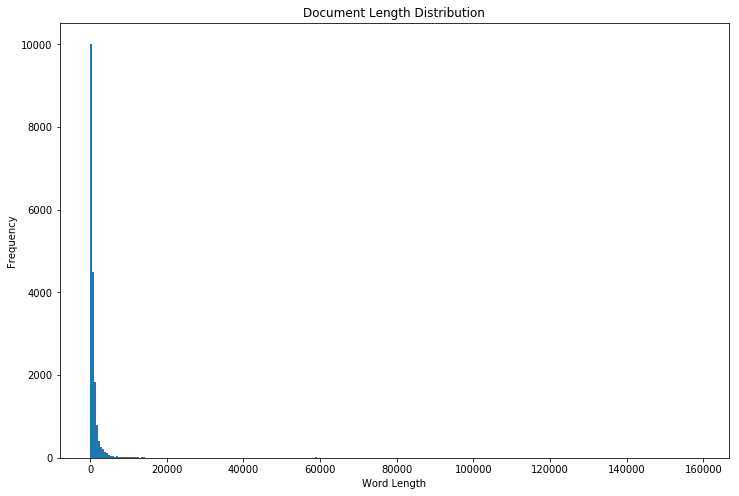

In [4]:
doc_len =[]
for doc in all_data:
    doc_len.append(len(doc))

# Document length statistics
print "Number of Samples: %i, Max Length: %i, Min Length: %i, Avg Length: %.3f, Median length: %.3f" \
    %(len(doc_len), max(doc_len), min(doc_len), np.mean(doc_len), np.median(doc_len))

plt.figure(figsize = (12, 8))
n, bins, patches = plt.hist(doc_len, 300)
plt.title("Document Length Distribution")
plt.xlabel("Word Length")
plt.ylabel("Frequency")
plt.show()

Based on the doucment length distribution, it is very skewed. We decided to use 500 words (around median) as document length so the distance to reduce the impact of padding and cutting of the document.

### 3. Build Vocabulary using 20 newsgroup data set

* Load all data from library => remove header/footer/quotes => clean string => create corpus => build vocabulary

* To build corpus, we write to raw txt, then use NLTK to process the raw text to a corpus

In [5]:
from nltk.corpus import PlaintextCorpusReader

f = open('./Data_Set/newsgroup_prep/newsgroup_all.txt', 'w') 
for doc in all_data:
    # Clean up str
    doc = utils.clean_str((doc).encode('utf-8'))
    # remove stop words and do stemming optionaly
    doc = utils.preprocess_stop_stem(doc, stop=True, sent=True, stem=False)
    f.write("%s\n" %(doc))
f.close()

# RegEx or list of file names
data_20newsgroup = os.path.join(PROJECT_DATA, 'newsgroup_prep/')

corpus = PlaintextCorpusReader(data_20newsgroup, 'newsgroup_all.txt')

for infile in sorted(corpus.fileids()):
    print infile # The fileids of each file.

newsgroup_all.txt


In [6]:
V = 20000
vocab = vocabulary.Vocabulary((utils.canonicalize_word(w) 
                               for w in utils.flatten(corpus.sents())),
                               size = V)
print "Vocabulary: %d words" % vocab.size

Vocabulary: 20000 words


### Experiment Data Setup

We decided to use the following subset of 20 newsgroup data for our experiment grids. We choose smaller number of classes and subtset of data. We hope to visualized clustering to get more intuition.

* 5 labeled class + 1 unknown class
* 5 labeled class + 2 unknown classes
* 5 labeled class + 3 unknown classes

#### Allow random selection of classes from the dataset

In [7]:
# Select training and test data based on the number of classes
# Including randomization option
import random
from random import randint
random.seed(8)

num_class = 7
randomize = True

if randomize == True:
    label_idxs = []
    label_idxs = random.sample(range(1, 19), num_class)
else:
    label_idxs = range(num_class)

select_classes = [label_list[i] for i in label_idxs]
print "Randomly Select Classes: ", select_classes

newsgroups_all = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'),
                                    categories=select_classes)

all_data, all_labels = newsgroups_all.data, newsgroups_all.target
print np.unique(all_labels)

Randomly Select Classes:  ['comp.windows.x', 'talk.politics.mideast', 'comp.sys.ibm.pc.hardware', 'sci.crypt', 'comp.os.ms-windows.misc', 'comp.sys.mac.hardware', 'sci.electronics']
[0 1 2 3 4 5 6]


#### Define document length and create training, cross-validation and test sets

In [8]:
doc_length = 500

# Preprocess data
# Cleaning special characters
# Cut or pad based on document length
all_docs = utils.preprocess_doc(all_data, length = doc_length)

# Split total data set to training and test set
train_docs, train_labels, test_docs, test_labels = utils.get_train_test_docs(all_docs, 
                                                                             all_labels, 
                                                                             split = 0.8, 
                                                                             shuffle = True)

# Further split training set into training and validation set
train_docs, train_labels, validation_docs, validation_labels = utils.get_train_val_docs(train_docs, 
                                                                                         train_labels, 
                                                                                         split = 0.75, 
                                                                                         shuffle = True)

Loaded 6833 docs (2.08186e+07 tokens)
Training set: 5466 docs (16656722 tokens)
Test set: 1367 docs (4161876 tokens)
Loaded 5466 docs (1.66567e+07 tokens)
Training set: 4372 docs (13313358 tokens)
Validation set: 1094 docs (3343364 tokens)


In [9]:
# Tokenize documents and conver to ID
# We tokenize each docs in the dataset and convert to vocab ID
# matrix of batch_size x doc_length
train_docs_ids = utils.docs_to_ids(train_docs, vocab)
validation_docs_ids = utils.docs_to_ids(validation_docs, vocab)
test_docs_ids = utils.docs_to_ids(test_docs, vocab)

# Convert label to one-hot-code
train_labels_oh = np.eye(num_class)[train_labels]
validation_labels_oh = np.eye(num_class)[validation_labels]
test_labels_oh = np.eye(num_class)[test_labels]

print "Input Training Docs shape:", train_docs_ids.shape, "should equal to (batch_size, doc_length)"
print "Input Training labels shape:", train_labels_oh.shape, "should equal to (batch_size, num_class)"
print "Input vaidation Docs shape:", validation_docs_ids.shape, "should equal to (batch_size, doc_length)"
print "Input Validation labels shape:", validation_labels_oh.shape, "should equal to (batch_size, num_class)"
print "Input Testing Docs shape:", test_docs_ids.shape, "should equal to (batch_size, doc_length)"
print "Input Testing labels shape:", test_labels_oh.shape, "should equal to (batch_size, num_class)"

Input Training Docs shape: (4372, 500) should equal to (batch_size, doc_length)
Input Training labels shape: (4372, 7) should equal to (batch_size, num_class)
Input vaidation Docs shape: (1094, 500) should equal to (batch_size, doc_length)
Input Validation labels shape: (1094, 7) should equal to (batch_size, num_class)
Input Testing Docs shape: (1367, 500) should equal to (batch_size, doc_length)
Input Testing labels shape: (1367, 7) should equal to (batch_size, num_class)


### 4. Prepare Data for the CNN

### Option 1. Train word Embedding with CNN. 

#### Tokenize document and build input data for word2vec

* Load data => remove header/footer/quotes => cleaned string => cut and pad => use vocabulary to tokenize

* Need to enable randomly select a number of classes for training and test data

* Instead of using Sk-learn's building selection of train or test data. Build our own train/test data based on %split

### Option 2 Load Google Pretrained Word2vec

In [10]:
def load_google_bin(fname, vocab):
    """
    Loads 300x1 word vecs from Google (Mikolov) word2vec
    """
    word_vecs = {}
    with open(fname, "rb") as f:
        header = f.readline()
        vocab_size, layer1_size = map(int, header.split())
        print "Google Word2vec Vocabulary Size:", vocab_size
        print "Vector size:", layer1_size
        binary_len = np.dtype('float32').itemsize * layer1_size
        print "Binary Length of word vector:", binary_len
        for line in xrange(vocab_size):
            word = []
            while True: # Read 1 char a time
                ch = f.read(1) 
                if ch == ' ': # If it is a space, a word is read, we join then to read its vector
                    word = ''.join(word)
                    break
                if ch != '\n': # If it is not \n, grouping character
                    word.append(ch) 
            if word in vocab.wordset: # If a word in the 20 newsgroup vocab, get its vector
                word_vecs[word] = np.fromstring(f.read(binary_len), dtype='float32')  
            else:
                f.read(binary_len)
    f.close()
    return word_vecs

In [11]:
google_word2vec = load_google_bin('./google_word2vec/GoogleNews-vectors-negative300.bin', vocab)

Google Word2vec Vocabulary Size: 3000000
Vector size: 300
Binary Length of word vector: 1200


In [12]:
print "Total Number of vocabulary in 20newsgroup:", vocab.size
print "Total matched vocabulary from google word2vec:", len(google_word2vec.keys())
print "--- Print a sample of google_word2vec vocabulary ---"
i = 0
for k, v in google_word2vec.iteritems():
    if i <= 10:
        print "Word: %s \t\t Vector: %s ..." %(k, v[:3])
    i += 1

Total Number of vocabulary in 20newsgroup: 20000
Total matched vocabulary from google word2vec: 16555
--- Print a sample of google_word2vec vocabulary ---
Word: raining 		 Vector: [ 0.02331543  0.05004883 -0.00059891] ...
Word: writings 		 Vector: [ 0.18945312  0.2109375   0.20507812] ...
Word: divinely 		 Vector: [-0.02783203 -0.40820312 -0.01037598] ...
Word: foul 		 Vector: [ 0.18847656 -0.28710938  0.33007812] ...
Word: four 		 Vector: [ 0.0859375  -0.07275391  0.01672363] ...
Word: gag 		 Vector: [ 0.14648438 -0.08203125 -0.00897217] ...
Word: prefix 		 Vector: [ 0.34570312  0.1640625   0.11425781] ...
Word: woods 		 Vector: [ 0.11328125 -0.01165771 -0.20800781] ...
Word: verses 		 Vector: [ 0.28710938  0.15820312  0.23828125] ...
Word: hanging 		 Vector: [ 0.08984375  0.13769531 -0.14941406] ...
Word: woody 		 Vector: [ 0.08251953  0.44140625  0.07421875] ...


#### Example vocabulary of the 20 newsgroup

In [13]:
regex = r'\b([A-Za-z]+)\b'
count_w = []
count_s = []
for word in vocab.wordset:    
    if re.search(regex, str(word)):
        count_w.append(str(word))
    else:
        count_s.append(str(word))

In [14]:
print "Number of full letter words", len(count_w)
print "Number of mixed ascii words", len(count_s)

Number of full letter words 18724
Number of mixed ascii words 1276


#### Take care of unknown words from 20newsgroup that does not exist in google word2vec

* 0.25 is chosen so the unknown vectors have (approximately) same variance as pre-trained ones

In [15]:
def add_unknown_words(google_word2vec, vocab, k=300):
    for word in vocab.wordset:
        if word not in google_word2vec:
            google_word2vec[word] = np.random.uniform(-0.25,0.25,k)  

In [16]:
add_unknown_words(google_word2vec, vocab, k=300)

In [17]:
print "Total Number of vocabulary in 20newsgroup:", vocab.size
print "Total matched vocabulary from google word2vec:", len(google_word2vec.keys())
pt_word2vec = np.array(google_word2vec.values())
print "Pre-trained word2vec size", pt_word2vec.shape

Total Number of vocabulary in 20newsgroup: 20000
Total matched vocabulary from google word2vec: 20000
Pre-trained word2vec size (20000, 300)


### CNN Illustrated

<img src="cnn.png" width = "80%">

### DOC Paper Terminology and Notes:

* Embedding Layer:

    * batch_size: N
    * number of class: M
    * A document matrix has size of $s \times d$
        * word embedding dimension: d => 300
        * doc length: s => 2000
    
    
* CNN Layer

    * Region size: h => [3, 4, 5]
    * Width of the filter: d => 300
    * Number of filters per region: f => 150
    * CNN out o: k => f x h = 150 x 3 = 450
    

* Output Layer
    * W: $M \times k$
    * y: $M$

Note: The DOC Paper used a 2 fully connected output layer before softmax which is different from common approach

$$out = Wo + b$$
    

### Define CNN Parameters

In [18]:
# CNN Paramters
# doc_length = 100 => to be aligned with DOC paper?
# num_class = 3 => to be adjusted based on stratified CV strategy from the DOC paper
# vocab.size => If we don't use google word2vec, it will be vocab.size from newsgroup data alone
# embedding_size => to be aligned with DOC paper
# filter_size = [3, 4] => to be aligned with DOC paper
# num_filters = 100 => to be aligned w

doc_length = doc_length # s
num_classes = num_class # M
vocab_size = vocab.size
embedding_size = 300 # d
embedding_train = False # if True, we train word embedding, if False we use pretrained word2vec
filter_sizes = [3, 4, 5]
num_filters = 150 # f
l2_reg_lambda = 0.0
dropout_prob = 1.0

In [19]:
# Placeholders for input, output and dropout
# x_: Document, Size: (batch, document_length) word in indice
# y_: Classes, Size: (batch, num_of_classes)
# dropout_keep_prob: Dropout regularization parameter
x_ = tf.placeholder(tf.int32, [None, doc_length], name="x")
y_ = tf.placeholder(tf.float32, [None, num_classes], name="y")
dropout_keep_prob = tf.placeholder(tf.float32, name="dropout_keep_prob")

# Keeping track of l2 regularization loss (optional)
l2_loss = tf.constant(0.0)

# Embedding layer (Train embedding layer)
# Need different implementation if use google pretrained word2vec
with tf.name_scope("Embedding_Layer"):
    # The vocab to vector table for lookup (to be trained or pre-trained)
    if embedding_train:
        C_ = tf.Variable(tf.random_uniform([vocab_size, embedding_size], -1.0, 1.0), name="C")
    else:
        C_ = tf.placeholder(tf.float32, [vocab_size, embedding_size], name="C")

    # Embedding output needs to be in size: (batch, doc_length, embedding_size, 1)
    # Lookup gives (batch, doc_length, embedding_size)
    # Therefore, we need to expand the dimension to 4D to work with conv2d
    embedded_out = tf.expand_dims(tf.nn.embedding_lookup(C_, x_), -1)

# Create a convolution + maxpool layer for each filter size
pooled_outputs = []
for i, filter_size in enumerate(filter_sizes):
    with tf.name_scope("conv-maxpool-%s" % filter_size):

        # Convolution Layer
        # input shape: (batch, height(doc length, width(embedding size), channels(1) )
        # filter shape: (filter_height, filter width(same as embedding size), in_channel, out_channels)
        # in_channel = 1 for our data
        # out_channel = num_filters
        filter_shape = [filter_size, embedding_size, 1, num_filters]

        # To experiment with normal distribution
        W_ = tf.Variable(tf.truncated_normal(filter_shape, stddev=0.1), name="W")
        b_ = tf.Variable(tf.constant(0.1, shape=[num_filters]), name="b")

        # "VALID" padding means no padding at edge
        # Return shape (batch, height(doc length, width(embedding size), 1)
        conv_ = tf.nn.conv2d(embedded_out, W_, strides=[1, 1, 1, 1], padding="VALID", name="conv")

        # Apply nonlinearity using Relu (train fasster than tanh)
        # Return shape (batch, height(doc length, 1, 1)
        h_ = tf.nn.relu(tf.nn.bias_add(conv_, b_), name="relu")

        # Maxpooling over the outputs
        # ksize is window for pooling, we took 1 value for width direction
        # For height, apply to each convolution steps to stripe the whole input matrix.
        # Return shape (1, doc_length-filter_size+1, 1, 1)
        pooled = tf.nn.max_pool(h_, 
                                ksize=[1, doc_length - filter_size + 1, 1, 1],
                                strides=[1, 1, 1, 1], 
                                padding='VALID', 
                                name="pool")
        pooled_outputs.append(pooled)

# Combine all the pooled features
# find the total number of filters = num_of_filters * num_of_region
# If we use [2, 3, 4] and 2 filter per region, we have 3 * 2 = 6 filters
num_filters_total = num_filters * len(filter_sizes)

# combine pooling output to feature vectors
# h_pool_flat in shape of (batch_size, ? , num_filters_total)
h_pool = tf.concat(pooled_outputs, 3)
h_pool_flat = tf.reshape(h_pool, [-1, num_filters_total])

# Add dropout
with tf.name_scope("dropout"):
    h_drop = tf.nn.dropout(h_pool_flat, dropout_keep_prob)

# Output Layer: Softmax
# Final (unnormalized) scores and predictions
# Do we need to normalize?
with tf.name_scope("Output_layer"):
    Z_ = tf.Variable(tf.random_uniform([num_filters_total, num_class], -1.0, 1.0), name = "Z")
    b_output_ = tf.Variable(tf.constant(0.1, shape=[num_class]), name="b_output")
    logits_ = tf.add(tf.matmul(h_drop, Z_), b_output_, name="logits")

    # L2 loss
    l2_loss += tf.nn.l2_loss(Z_)
    l2_loss += tf.nn.l2_loss(b_)

    #scores = tf.nn.xw_plus_b(h_drop, W, b, name="scores")
    predictions_ = tf.argmax(logits_, 1, name="predictions")

# Calculate mean cross-entropy loss
with tf.name_scope("cost_function"):
    per_example_losses_ = tf.nn.softmax_cross_entropy_with_logits(logits=logits_, 
                                                                 labels=y_,
                                                                 name="per_example_loss")
    loss_ = tf.reduce_mean(per_example_losses_) + l2_reg_lambda * l2_loss

# Accuracy
with tf.name_scope("accuracy"):
    correct_predictions_ = tf.equal(predictions_, tf.argmax(y_, 1))
    accuracy_ = tf.reduce_mean(tf.cast(correct_predictions_, "float"), name="accuracy")

with tf.name_scope("Training"):
    alpha_ = tf.placeholder(tf.float32, name="learning_rate")
    optimizer_ = tf.train.AdagradOptimizer(alpha_)
    #optimizer_ = tf.train.AdamOptimizer(alpha_)
    train_step_ = optimizer_.minimize(loss_)

### Training with CNN

#### Helper functions for Training

In [20]:
# Helper functions for training
def display_params():
    print "doc_length: {:<10d}".format(doc_length) # s
    print "num_classes: {:<10d}".format(num_class) # M
    print "vocabulary size: {:<10d}".format(vocab.size)
    print "embedding size: {:<10d}".format(embedding_size) # d
    print "Train embedding? ", embedding_train
    print "filter size: {:<10s}".format(filter_sizes)
    print "number of filters: {:<10d}".format(num_filters)
    print "L2 Regularization: {:<10.2f}".format(l2_reg_lambda)
    print "Keep drop out prob: {:<10.2f}".format(dropout_prob)
    
def train_batch(session, batch, alpha, train_embedding):
    # Feed last column as targets
    if train_embedding:
        feed_dict = {x_:train_docs_ids,
                     y_:train_labels_oh,
                     dropout_keep_prob:dropout_prob, # No dropout
                     alpha_:alpha}
    else:
        feed_dict = {x_:train_docs_ids,
                     y_:train_labels_oh,
                     C_:pt_word2vec, # use google word2vec
                     dropout_keep_prob:dropout_prob, # No dropout
                     alpha_:alpha}
    c, a, pred, _ = session.run([loss_, accuracy_, predictions_, train_step_],
                       feed_dict=feed_dict)
    return c, a, pred

def validation_batch(session):
    feed_dict = {x_:test_docs_ids,
                 y_:test_labels_oh,
                 C_:pt_word2vec,
                 dropout_keep_prob:dropout_prob}
    a, pred = session.run([accuracy_, predictions_, ], feed_dict=feed_dict)
    return a, pred

def batch_generator(data, batch_size):
    """Generate minibatches from data."""
    for i in xrange(0, len(data), batch_size):
        yield data[i:i+batch_size]
        
def predict_batch_te(session):
    feed_dict = {x_:test_docs_ids,
                 y_:test_labels_oh,
                 dropout_keep_prob:dropout_prob}
    a, pred = session.run([accuracy_, predictions_], feed_dict=feed_dict)
    return a, pred

def predict_batch_w2v(session):
    feed_dict = {x_:test_docs_ids,
                 y_:test_labels_oh,
                 C_:pt_word2vec,
                 dropout_keep_prob:dropout_prob}
    a, pred = session.run([accuracy_, predictions_, ], feed_dict=feed_dict)
    return a, pred

#### Training Run

In [46]:
def run_epochs(num_epoches, learning_rate, trained_filename, batch_size = 100,
               min_rate = 0.1, print_freq = 10, seed = 42, train_embedding = True):
# One epoch = one pass through the training data
    num_epochs = num_epoches
    batch_size = batch_size
    alpha = learning_rate  # learning rate
    min_alpha = min_rate
    alpha_delta = (alpha - min_alpha) / num_epochs
    print_every = print_freq

    # Initializer step
    init_ = tf.global_variables_initializer()
    np.random.seed(seed)
    
    # Add ops to save and restore all the variables.
    saver = tf.train.Saver()
    
    # For plotting
    train_accuracy = []
    test_accuracy = []

    session = tf.Session()
    session.run(init_)

    t0 = time.time()
    for epoch in xrange(1,num_epochs+1):
        t0_epoch = time.time()
        epoch_cost = 0.0
        total_batches = 0
        print ""
        print "----------- Training ------------"
        for i, batch in enumerate(batch_generator(train_docs_ids, batch_size)):
            if (i % print_every == 0):
                print "[epoch %d] seen %d minibatches" % (epoch, i)

            cost, accuracy, pred = train_batch(session, batch, alpha, train_embedding)
            epoch_cost += cost
            total_batches = i + 1

        avg_cost = epoch_cost / total_batches
        alpha = alpha - alpha_delta

        print "[epoch %d] Completed %d minibatches in %s" % (epoch, i, utils.pretty_timedelta(since=t0_epoch))
        print "[epoch %d] Average cost: %.03f" % (epoch, avg_cost,)
        print "[epoch %d] Accuracy %.03f" %(epoch, accuracy)
        print "[epoch %d] Training Classificaiton Report\n" %(epoch)
        print classification_report(train_labels, pred)
        print "Training Vector Accuracy: ", accuracy_score(train_labels, pred)
        train_accuracy.append(accuracy)
        
        print ""
        print "---------- Test ----------"
        if train_embedding:
            accuracy, pred = predict_batch_te(session)
        else:
            accuracy, pred = predict_batch_w2v(session)
        print "[epoch %d] Test Accuracy is %.03f" %(epoch, accuracy)
        print "[epoch %d] Test Classificaiton Report\n" %(epoch)
        print classification_report(test_labels, pred)
        print "Test Vector Accuracy:", accuracy_score(test_labels, pred)
        test_accuracy.append(accuracy)
        
    # Save the variables to disk.
    save_path = saver.save(session, "/tmp/model")
    print("Model saved in file: %s" % save_path)
    
    return train_accuracy, test_accuracy, session
        
def plot_learning(num_epochs, train_accuracy, test_accuracy):
    plt.figure(figsize=(10, 8))
    plt.plot(range(0, num_epochs), train_accuracy, '.-', label = "Training accuracy")
    plt.plot(range(0, num_epochs), test_accuracy, '.-', label = "Test accuracy")
    plt.legend()
    plt.show()

### CV Decision 1. Google word2vec vs. Training word embedding on the fly using 

* 5 classes
* no regularization

#### Google Word2Vec

In [37]:
display_params()

doc_length: 500       
num_classes: 8         
vocabulary size: 20000     
embedding size: 300       
Train embedding?  False
filter size: [3, 4, 5] 
number of filters: 150       
L2 Regularization: 0.00      
Keep drop out prob: 1.00      


In [30]:
train_accur, test_accur, sess = run_epochs(num_epoches = 5,
                                           learning_rate = 0.5, 
                                           batch_size = 100,
                                           min_rate = 0.1, 
                                           print_freq = 10, 
                                           seed = 42, 
                                           train_embedding = embedding_train)


----------- Training ------------
[epoch 1] seen 0 minibatches
[epoch 1] seen 10 minibatches
[epoch 1] seen 20 minibatches
[epoch 1] seen 30 minibatches
[epoch 1] Completed 31 minibatches in 0:21:28
[epoch 1] Average cost: 41.010
[epoch 1] Accuracy 0.761
[epoch 1] Training Classificaiton Report

             precision    recall  f1-score   support

          0       0.49      0.87      0.63       646
          1       0.91      0.59      0.71       615
          2       0.92      0.83      0.87       645
          3       0.92      0.72      0.81       641
          4       0.93      0.79      0.85       579

avg / total       0.83      0.76      0.77      3126

Training Vector Accuracy:  0.761356365963

---------- Test ----------
[epoch 1] Test Accuracy is 0.483
[epoch 1] Test Classificaiton Report

             precision    recall  f1-score   support

          0       0.30      0.62      0.41       176
          1       0.51      0.33      0.40       202
          2       0.66     

#### Train word embedding on the fly

In [40]:
display_params()

doc_length: 500       
num_classes: 5         
vocabulary size: 20000     
embedding size: 300       
Train embedding?  True
filter size: [3, 4, 5] 
number of filters: 150       
L2 Regularization: 0.00      
Keep drop out prob: 1.00      


In [41]:
train_accur, test_accur = run_epochs(num_epoches = 5,
                                     learning_rate = 0.5, 
                                     batch_size = 100,
                                     min_rate = 0.1, 
                                     print_freq = 10, 
                                     seed = 42, 
                                     train_embedding = embedding_train)


----------- Training ------------
[epoch 1] seen 0 minibatches
[epoch 1] seen 10 minibatches
[epoch 1] seen 20 minibatches
[epoch 1] seen 30 minibatches
[epoch 1] Completed 31 minibatches in 0:22:15
[epoch 1] Average cost: 380.543
[epoch 1] Accuracy 0.900
[epoch 1] Training Classificaiton Report

             precision    recall  f1-score   support

          0       0.74      0.90      0.81       646
          1       0.92      0.91      0.91       615
          2       0.99      0.90      0.94       645
          3       0.98      0.90      0.94       641
          4       0.93      0.88      0.90       579

avg / total       0.91      0.90      0.90      3126

Training Vector Accuracy:  0.899552143314

---------- Test ----------
[epoch 1] Test Accuracy is 0.415
[epoch 1] Test Classificaiton Report

             precision    recall  f1-score   support

          0       0.36      0.41      0.38       176
          1       0.52      0.36      0.43       202
          2       0.38    

** Conclusion: Google word2vec out-perform training word-embedding on the fly. We use google word2vec for our word embedding layer **

## 2. Open Classificaiton Methods (1-vs-Rest)

* 1-vs-Rest Layer of DOC

    * M (number of class) sigmoid function, N (batch_size)
    * Objective function for training is $$loss = \sum_{i=1}^M \sum_{i=1}^N y_n log(p) + (1 - y_n)log(1 - p(y))$$ is the summation of all log loss (cross-entropy) on the training data.
    * At prediction, reject if all predicted probability is less than their threshold t_i, otherwise $argmax(Sigmoid(d))$
    * The theshold is determined by using outlier detection. (***We can use a fixed number such as 0.95 to validate our model implementation***)
    * Approach:
        1. Remove some classes from the training data
        2. Training the data
        3. Add those classes back to the test data

* Clustering Approach
    * KNN
    * Gausian Mix Model
    * Infinite Dirichlet process

### Use Google word2vec for CNN Model

** Cross Validation Run Epochs **

In [23]:
def run_epochs_cv(num_epoches, learning_rate, batch_size = 100, 
                  min_rate = 0.1, print_freq = 10, seed = 42, train_embedding = True):
# One epoch = one pass through the training data
    num_epochs = num_epoches
    batch_size = batch_size
    alpha = learning_rate  # learning rate
    min_alpha = min_rate
    alpha_delta = (alpha - min_alpha) / num_epochs
    print_every = print_freq

    # Initializer step
    init_ = tf.global_variables_initializer()
    
    # Add ops to save and restore all the variables.
    saver = tf.train.Saver()
    
    np.random.seed(seed)
    
    # For plotting
    train_accuracy = []
    test_accuracy = []

    session = tf.Session()
    session.run(init_)

    t0 = time.time()
    for epoch in xrange(1,num_epochs+1):
        t0_epoch = time.time()
        epoch_cost = 0.0
        total_batches = 0
        print ""
        print "----------- Training ------------"
        for i, batch in enumerate(batch_generator(train_docs_ids, batch_size)):
            if (i % print_every == 0):
                print "[epoch %d] seen %d minibatches" % (epoch, i)

            cost, accuracy, pred = train_batch(session, batch, alpha, train_embedding)
            epoch_cost += cost
            total_batches = i + 1

        avg_cost = epoch_cost / total_batches
        alpha = alpha - alpha_delta

        print "[epoch %d] Completed %d minibatches in %s" % (epoch, i, utils.pretty_timedelta(since=t0_epoch))
        print "[epoch %d] Average cost: %.03f" % (epoch, avg_cost,)
        print "[epoch %d] Accuracy %.03f" %(epoch, accuracy)
        print "[epoch %d] Training Classificaiton Report\n" %(epoch)
        print classification_report(train_labels, pred)
        print "Training Vector Accuracy: ", accuracy_score(train_labels, pred)
        train_accuracy.append(accuracy)
        
        print ""
        print "---------- Validation ----------"
        accuracy, pred = validation_batch(session)
        print "[epoch %d] Validation Accuracy is %.03f" %(epoch, accuracy)
        print "[epoch %d] Validation Classificaiton Report\n" %(epoch)
        print classification_report(test_labels, pred)
        print "Test Vector Accuracy:", accuracy_score(test_labels, pred)
        test_accuracy.append(accuracy)        

    # Save the variables to disk.
    save_path = saver.save(session, "/tmp/model")
    print("Model saved in file: %s" % save_path)
    
    return train_accuracy, test_accuracy, session

## Case 1 (5 labeled + 1 unseen)

### Remove 1 class and cross validate train data for hyper parameters

** Params **

In [48]:
doc_length = doc_length # s
num_classes = num_class # M
vocab_size = vocab.size
embedding_size = 300 # d
embedding_train = False # We use pretrained word2vec
filter_sizes = [3, 4, 5]
num_filters = 150
l2_reg_lambda = 0.5
dropout_prob = 1.0
display_params()

doc_length: 500       
num_classes: 6         
vocabulary size: 20000     
embedding size: 300       
Train embedding?  False
filter size: [3, 4, 5] 
number of filters: 150       
L2 Regularization: 0.50      
Keep drop out prob: 1.00      


In [49]:
train_accur, test_accur, sess = run_epochs_cv(num_epoches = 5,
                                              learning_rate = 0.5, 
                                              batch_size = 100,
                                              min_rate = 0.1, 
                                              print_freq = 10, 
                                              seed = 42, 
                                              train_embedding = embedding_train)


----------- Training ------------
[epoch 1] seen 0 minibatches
[epoch 1] seen 10 minibatches
[epoch 1] seen 20 minibatches
[epoch 1] seen 30 minibatches
[epoch 1] Completed 37 minibatches in 0:21:11
[epoch 1] Average cost: 54.312
[epoch 1] Accuracy 0.707
[epoch 1] Training Classificaiton Report

             precision    recall  f1-score   support

          0       0.84      0.63      0.72       630
          1       0.40      0.78      0.53       631
          2       0.85      0.61      0.71       629
          3       0.83      0.75      0.79       619
          4       0.84      0.74      0.79       620
          5       0.92      0.74      0.82       614

avg / total       0.78      0.71      0.72      3743

Training Vector Accuracy:  0.706919583222

---------- Validation ----------
[epoch 1] Validation Accuracy is 0.393
[epoch 1] Validation Classificaiton Report

             precision    recall  f1-score   support

          0       0.52      0.33      0.40       202
         

## Case 2 (5 labeled + 2 unseen)

### Remove 2 class and cross validate train data for hyper parameters

In [24]:
doc_length = doc_length # s
num_classes = num_class # M
vocab_size = vocab.size
embedding_size = 300 # d
embedding_train = False # We use pretrained word2vec
filter_sizes = [3, 4, 5]
num_filters = 150
l2_reg_lambda = 0.5
dropout_prob = 1.0
display_params()

doc_length: 500       
num_classes: 7         
vocabulary size: 20000     
embedding size: 300       
Train embedding?  False
filter size: [3, 4, 5] 
number of filters: 150       
L2 Regularization: 0.50      
Keep drop out prob: 1.00      


In [25]:
train_accur, test_accur, sess = run_epochs_cv(num_epoches = 5,
                                              learning_rate = 0.5, 
                                              batch_size = 100,
                                              min_rate = 0.1, 
                                              print_freq = 10, 
                                              seed = 42, 
                                              train_embedding = embedding_train)


----------- Training ------------
[epoch 1] seen 0 minibatches
[epoch 1] seen 10 minibatches
[epoch 1] seen 20 minibatches
[epoch 1] seen 30 minibatches
[epoch 1] seen 40 minibatches
[epoch 1] Completed 43 minibatches in 0:28:57
[epoch 1] Average cost: 67.917
[epoch 1] Accuracy 0.655
[epoch 1] Training Classificaiton Report

             precision    recall  f1-score   support

          0       0.29      0.69      0.41       621
          1       0.81      0.55      0.65       625
          2       0.89      0.65      0.75       617
          3       0.75      0.72      0.73       619
          4       0.83      0.67      0.75       660
          5       0.81      0.56      0.66       641
          6       0.95      0.74      0.83       589

avg / total       0.76      0.65      0.68      4372

Training Vector Accuracy:  0.65462031107

---------- Validation ----------
[epoch 1] Validation Accuracy is 0.400
[epoch 1] Validation Classificaiton Report

             precision    recall  

## Case 3 (5 labeled + 3 unseen)

### Remove 2 class and cross validate train data for hyper parameters

In [47]:
doc_length = doc_length # s
num_classes = num_class # M
vocab_size = vocab.size
embedding_size = 300 # d
embedding_train = False # We use pretrained word2vec
filter_sizes = [3, 4, 5]
num_filters = 150
l2_reg_lambda = 0.5
dropout_prob = 1.0
display_params()

doc_length: 500       
num_classes: 8         
vocabulary size: 20000     
embedding size: 300       
Train embedding?  False
filter size: [3, 4, 5] 
number of filters: 150       
L2 Regularization: 0.50      
Keep drop out prob: 1.00      


In [48]:
train_accur, test_accur, sess = run_epochs_cv(num_epoches = 5,
                                              learning_rate = 0.5, 
                                              batch_size = 100,
                                              min_rate = 0.1, 
                                              print_freq = 10, 
                                              seed = 42, 
                                              train_embedding = embedding_train)


----------- Training ------------
[epoch 1] seen 0 minibatches
[epoch 1] seen 10 minibatches
[epoch 1] seen 20 minibatches
[epoch 1] seen 30 minibatches
[epoch 1] seen 40 minibatches
[epoch 1] Completed 49 minibatches in 0:36:50
[epoch 1] Average cost: 62.546
[epoch 1] Accuracy 0.643
[epoch 1] Training Classificaiton Report

             precision    recall  f1-score   support

          0       0.74      0.55      0.63       643
          1       0.28      0.71      0.40       624
          2       0.87      0.54      0.67       606
          3       0.83      0.79      0.81       658
          4       0.73      0.67      0.70       639
          5       0.82      0.55      0.66       615
          6       0.81      0.65      0.72       594
          7       0.94      0.66      0.78       576

avg / total       0.75      0.64      0.67      4955

Training Vector Accuracy:  0.642583249243

---------- Validation ----------
[epoch 1] Validation Accuracy is 0.356
[epoch 1] Validation Cla